In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler


In [306]:
#Importing the data as dataframe
df = pd.read_csv("customers_all_processed_wo_email.csv")
#feeling in all the empty data
opt_df = df.fillna(0)
#replacing the data into the column with only ones
opt_df['IS_ENGAGED_CUST'] = np.where(opt_df['IS_ENGAGED_CUST'] == 0, 1,1)




In [307]:
#Rule that determins engaged customer
opt_df["IS_ENGAGED_CUST"] = np.where(((opt_df["TRN_COUNT"] < 2) & (opt_df['CUST_LAST_LOGIN_DAYS'] > 90) & (opt_df["DAYS_BTW_REG_AND_LAST_TRN"] < 3)) | ((opt_df['TRN_CNT_LST_YEAR'] == 0) & (opt_df['CUST_LAST_LOGIN_DAYS'] > 60) &~ (opt_df['HAS_RECUR_TRN'])) == 1, 0,1)

#Cutting out not needed data
opt_df = opt_df.loc[:,'CUST_LAST_LOGIN_DAYS':'IS_ENGAGED_CUST']
opt_df

,CUST_LAST_LOGIN_DAYS,TRN_COUNT,TRN_CNT_LST_YEAR,AVG_TRN_AMT,DAYS_AFTER_LAST_TRN,DAYS_BTW_REG_AND_LAST_TRN,ORDERER_PHY_CARD,HAS_RECUR_TRN,IS_ENGAGED_CUST
0,6,12,12,5,6,0,0,0,1
1,1000,6,6,8,10,0,0,0,1
2,1000,4,4,3,10,0,0,0,1
3,1000,6,6,5,10,0,0,0,1
4,1000,9,9,3,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...
6749201,1000,0,0,0,0,0,0,0,0
6749202,1000,0,0,0,0,0,0,0,0
6749203,1000,0,0,0,0,0,0,0,0
6749204,1000,0,0,0,0,0,0,0,0


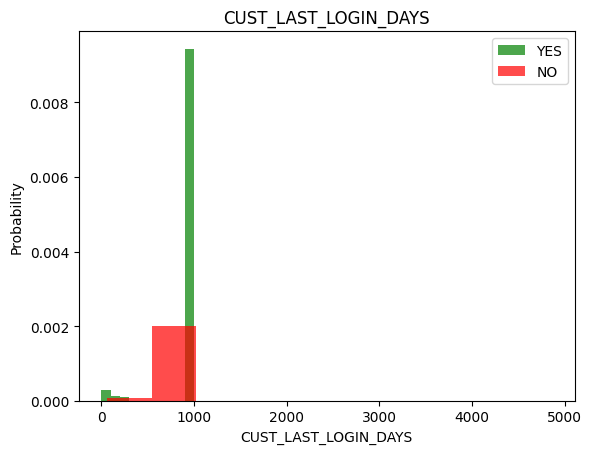

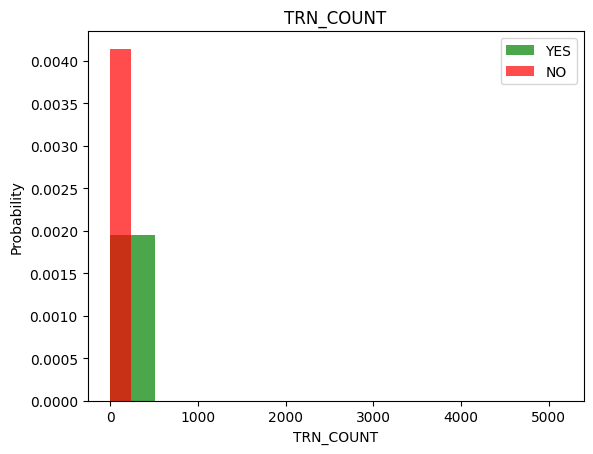

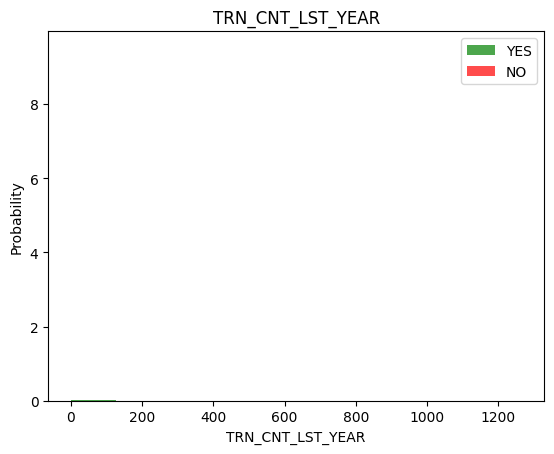

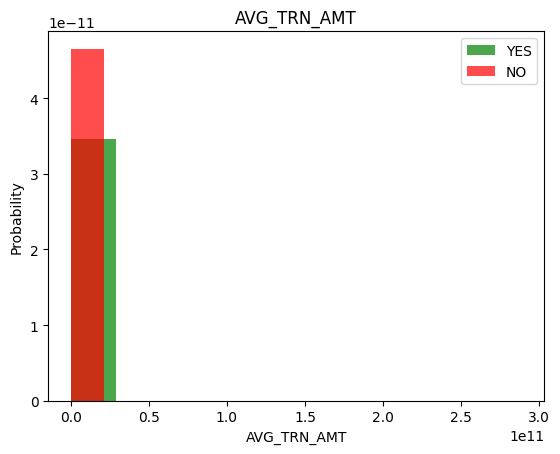

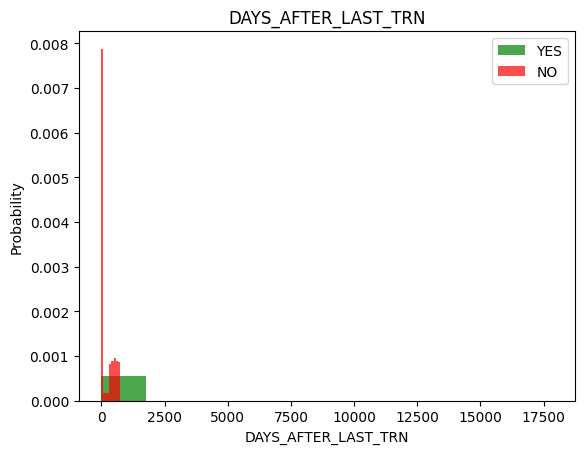

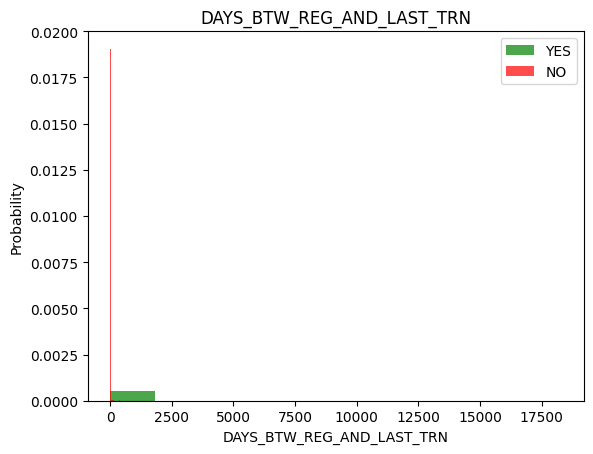

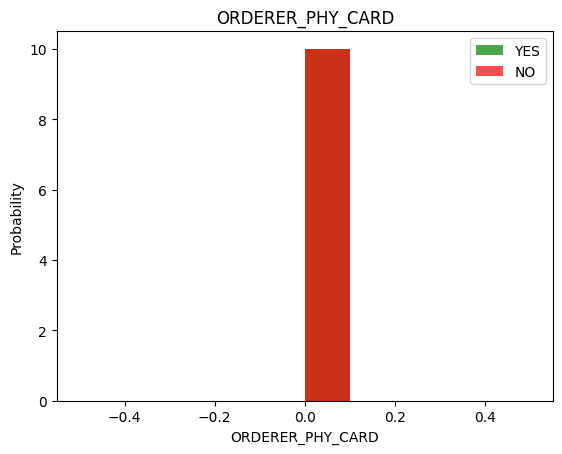

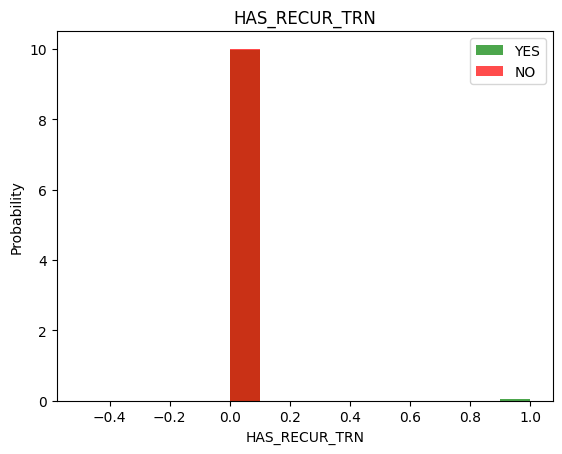

In [308]:
#plotting data 
for label in opt_df.columns[:-1]:
    plt.hist(opt_df[opt_df['IS_ENGAGED_CUST'] == 1][label], color = 'green', label = "YES", alpha = 0.7, density = True)
    plt.hist(opt_df[opt_df['IS_ENGAGED_CUST'] == 0][label], color = 'red', label = "NO", alpha = 0.7, density = True)
    plt.title(label)
    plt.ylabel('Probability')
    plt.xlabel(label)
    plt.legend()
    plt.show()

In [309]:
#Deviding the data into 3 section. 60% training, 20% validation, 20% testing.
train, valid, test = np.split(opt_df.sample(frac=1), [int(0.6 * len(opt_df)), int(0.8 * len(opt_df))])


train[train['IS_ENGAGED_CUST'] == 1]

/opt/homebrew/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,CUST_LAST_LOGIN_DAYS,TRN_COUNT,TRN_CNT_LST_YEAR,AVG_TRN_AMT,DAYS_AFTER_LAST_TRN,DAYS_BTW_REG_AND_LAST_TRN,ORDERER_PHY_CARD,HAS_RECUR_TRN,IS_ENGAGED_CUST
6488790,1000,9,9,49,144,0,0,0,1
6004702,1000,6,6,43,227,0,0,0,1
3646067,1000,6,6,37,240,0,0,0,1
5714757,1000,3,3,16,195,0,0,0,1
5269806,1000,4,4,5403,56,0,0,0,1
...,...,...,...,...,...,...,...,...,...
5690723,1000,8,8,12,168,0,0,0,1
6135319,1000,4,4,23,220,0,0,0,1
5510618,1000,5,5,28,118,0,0,0,1
5749278,1000,3,3,17,175,0,0,0,1


In [312]:
#function for converting the dataframe into numpy arrays, scaling and oversapling
def data_scaler(data_frame, oversample=False):
    x = data_frame[data_frame.columns[:-1]].values
    y = data_frame[data_frame.columns[-1]].values

    global scaler
    scaler = MinMaxScaler()
    scaler.fit(x)
    x = scaler.transform(x)

    if oversample:
        ov = RandomOverSampler()
        x, y = ov.fit_resample(x, y)

    data = np.hstack((x, np.reshape(y, (-1, 1))))
    
    return data, x, y

In [313]:
#executing function
train, x_train, y_train = data_scaler(train, oversample=True)
valid, x_valid, y_valid = data_scaler(test, oversample=False)
test, x_test, y_test = data_scaler(test, oversample=False)

In [314]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [ ]:
#training the moodel
lg = LogisticRegression()
lg = lg.fit(x_train, y_train)

In [ ]:
#model making predictions
y_pred = lg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92   1107007
           1       0.98      0.19      0.31    242835

    accuracy                           0.85   1349842
   macro avg       0.92      0.59      0.62   1349842
weighted avg       0.87      0.85      0.81   1349842



In [315]:
#descaling the scaled data for better plotting
x_test = scaler.inverse_transform(x_test)
x_test = x_test.astype(int)

In [320]:
#Converting the numpy arrays into dataframe tabels
pred_df_x = pd.DataFrame(x_test, columns=["CUST_LAST_LOGIN_DAYS",	 "TRN_COUNT", 	"TRN_CNT_LST_YEAR",	"AVG_TRN_AMT",	"DAYS_AFTER_LAST_TRN",	"DAYS_BTW_REG_AND_LAST_TRN", "ORDERER_PHY_CARD","HAS_RECUR_TRN"])
pred_df_y = pd.DataFrame(y_test, columns=['IS_ENGAGDE_CUST'])
pred_df_p = pd.DataFrame(y_pred, columns=['IS_ENGAGDE_CUST1'])



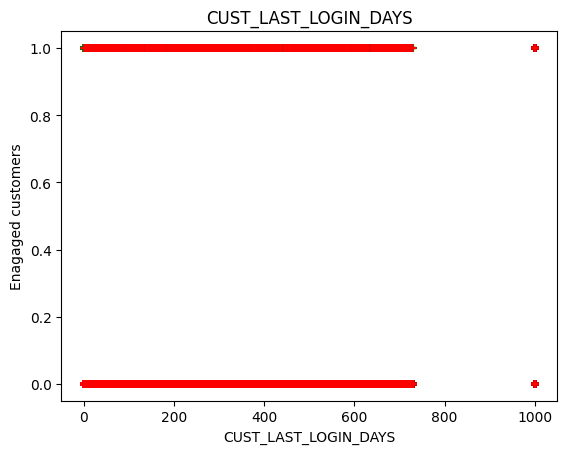

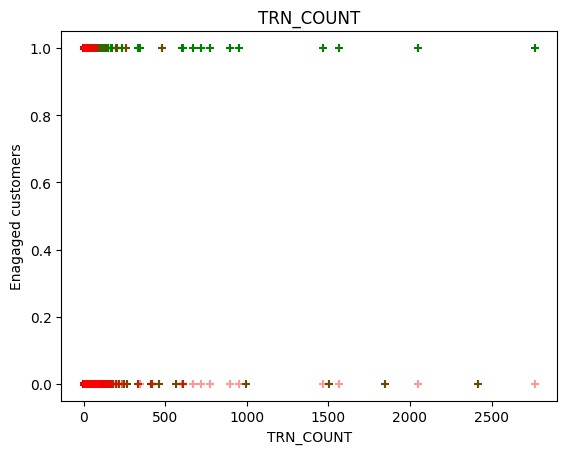

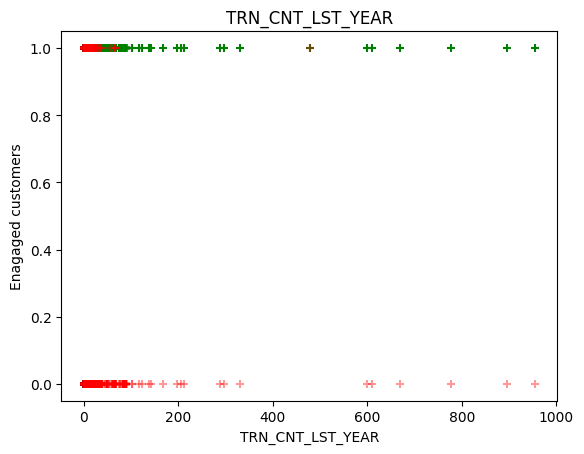

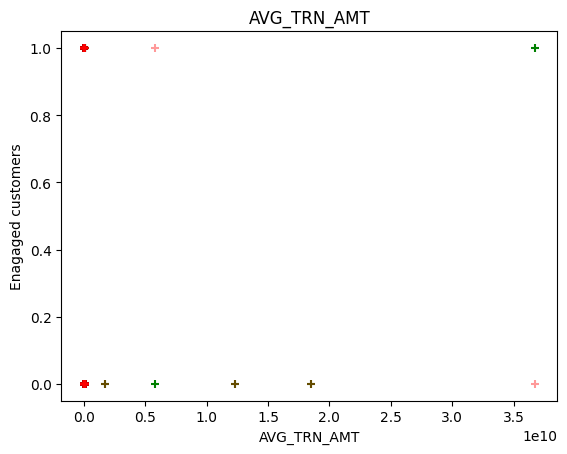

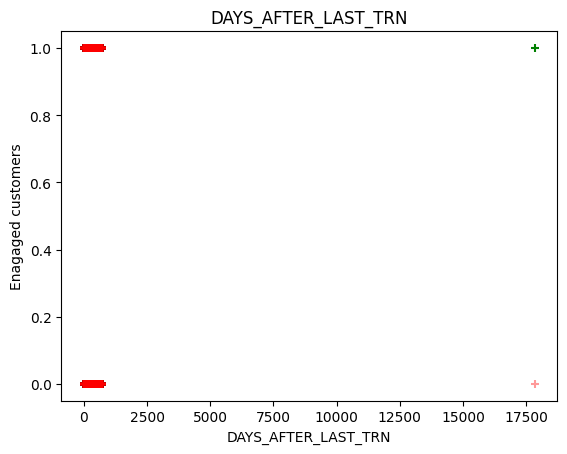

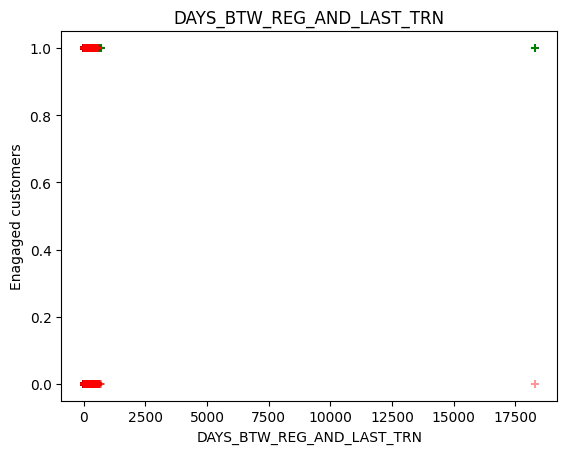

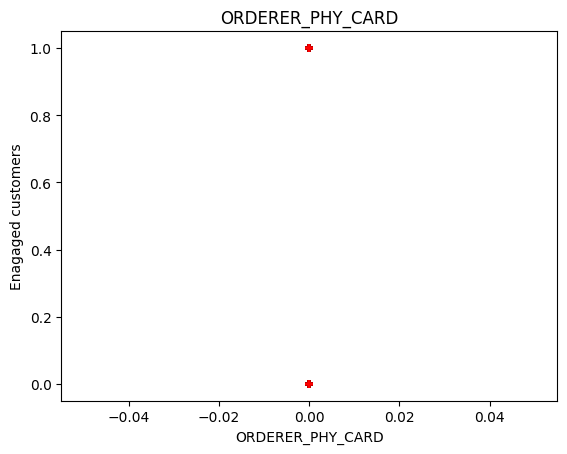

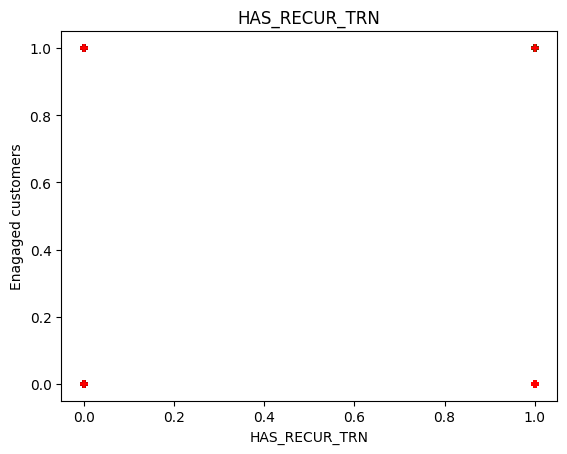

In [342]:
#plotting the predicted y values(red) and actual values(green)
for label in pred_df_x:
    plt.scatter(pred_df_x[label], pred_df_y, marker="+", color='green', alpha=1)
    plt.scatter(pred_df_x[label], pred_df_p, marker="+", color="red", alpha=0.4)
    plt.xlabel(label)
    plt.ylabel("Enagaged customers")
    plt.title(label)
    plt.show()